In [1]:
using MLDatasets
using ImageCore
using LinearAlgebra
using PyPlot
using Random
using Statistics
using Printf
using JLD2, FileIO
using ProgressMeter
include("HyperECNNs.jl")
rng = MersenneTwister(1234);

In [2]:
if ~isdir("JLDs")
    mkdir("JLDs")
    print("Created a folder to save jld2 files.")
end

In [3]:
function cifar2gray(x)
    return round.(Int,255*(0.2989*x[:,:,1,1] + 0.5870*x[:,:,2,1]+ 0.1140*x[:,:,3,1]))
end

function gray2multistate(x,K)
    zsize = size(x)
    z = exp.(2.0*pi*x*im/K)[:]
    return hcat(real.(z),imag.(z)), zsize
end

function multistate2gray(y,K,ysize)
    z = y[:,1]+y[:,2]*im
    return reshape(Array{Int64}((round.(K*(2*pi.+angle.(z))./(2*pi))).%K),ysize)
end

function imnoise(img,noise_std = 0.1)
    return clamp.(img + noise_std*randn(rng, Float64, size(img)),0,1)
end

imnoise (generic function with 2 methods)

In [4]:
# load full training set
train_x, train_y = CIFAR10.traindata();

In [5]:
x = cifar2gray(train_x[:,:,:,3]);

In [6]:
K = 256
xc, xsize = gray2multistate(x,K);

In [7]:
y = multistate2gray(xc,K,xsize);

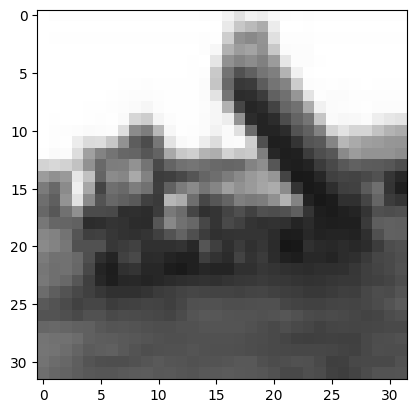

0.0

In [8]:
imshow(transpose(y),cmap=get_cmap("gray"), vmin=0, vmax=255)
norm(x-y)

In [9]:
P = 200
# Indexes of the fundamental memories
indFM = randperm(rng, size(train_x)[4])[1:P];

In [10]:
# Bipolar fundamental memory set
N = 32*32
K = 256
U = Array{Real}(undef,N,2,P)
for i=1:P
    uc, usize = gray2multistate(cifar2gray(train_x[:,:,:,indFM[i]]),K)
    U[:,:,i] = uc
end

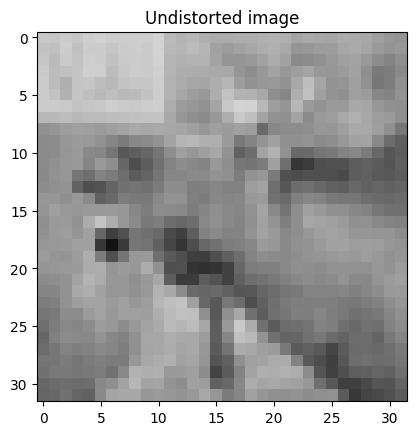

PyObject Text(0.5, 1.0, 'Undistorted image')

In [11]:
imgx = cifar2gray(train_x[:,:,:,indFM[1]])
imshow(transpose(imgx),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Undistorted image")

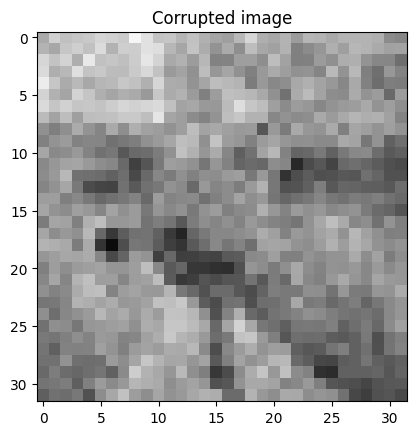

PyObject Text(0.5, 1.0, 'Corrupted image')

In [12]:
imgxr = cifar2gray(imnoise(train_x[:,:,:,indFM[1]],20/255))
x, xsize = gray2multistate(imgxr,K)
imshow(transpose(imgxr),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Corrupted image")

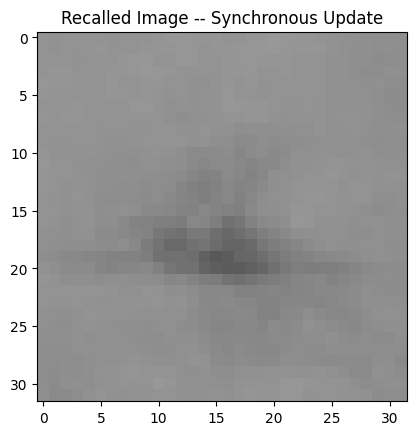

(441.1099636145164, 967.3949555378093)


(1101.953125, 2378.61328125)

In [13]:
alpha = 10/N
beta = -10
y, Energy = HyperECNNs.Sync(HyperECNNs.LambdaInner,[1,1],HyperECNNs.csign,K,
    U,x,alpha,beta)
imgy = multistate2gray(y,K,xsize)
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Recalled Image -- Synchronous Update")
println((norm(imgx-imgxr),norm(imgx-imgy)))
(100*sum(abs.(imgx-imgxr))/N,100*sum(abs.(imgx-imgy))/N)

In [14]:
N = 32*32

alpha = 20/N
beta = -20

P = 200
K = 256

Nsim = 100
NoiseValues = range(0,stop=150,step=5)/255
Nnoise = length(NoiseValues)

SuccessCvMultistate_Sync = zeros(Int64,(Nnoise,))
SuccessCvMultistate_Seq = zeros(Int64,(Nnoise,))

@showprogress for s = 1:Nsim
    # Generate the fundamental memory set!
    indFM = randperm(rng, size(train_x)[4])[1:P]
    U = Array{Real}(undef,N,2,P)
    for i=1:P
        uc, usize = gray2multistate(cifar2gray(train_x[:,:,:,indFM[i]]),K)
        U[:,:,i] = uc
    end
    for i = 1:Nnoise
        # Generate a corrupted pattern
        imgx = cifar2gray(train_x[:,:,:,indFM[1]])
        imgxr = cifar2gray(imnoise(train_x[:,:,:,indFM[1]],NoiseValues[i]))
        x, xsize = gray2multistate(imgxr,K)
        
        # Recall using synchronous update
        y, Energy = HyperECNNs.Sync(HyperECNNs.LambdaInner,[1,1],HyperECNNs.csign,K,U,x,alpha,beta)
        imgy = multistate2gray(y,K,xsize)
        Error = norm(imgx-imgy)
        if Error<1.e-4
            SuccessCvMultistate_Sync[i] = SuccessCvMultistate_Sync[i] + 1
        end
        
        # Recall using asynchronous update
        y, Energy = HyperECNNs.Seq(HyperECNNs.LambdaInner,[1,1],HyperECNNs.csign,K,U,x,alpha,beta)
        imgy = multistate2gray(y,K,xsize)
        Error = norm(imgx-imgy)
        if Error<1.e-4
            SuccessCvMultistate_Seq[i] = SuccessCvMultistate_Seq[i] + 1
        end
    end
    @save "JLDs/CIFARCvMultistate.jld2" SuccessCvMultistate_Sync SuccessCvMultistate_Seq NoiseValues Nsim
end

Progress: 100%|█████████████████████████████████████████| Time: 0:53:25


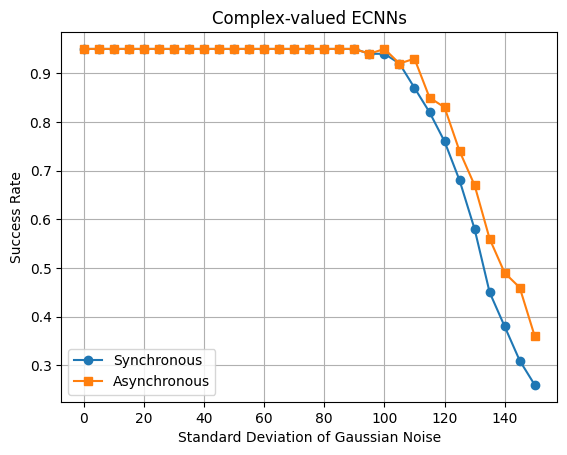

In [15]:
@load "JLDs/CIFARCvMultistate.jld2"
plot(255*NoiseValues,SuccessCvMultistate_Sync/Nsim, marker="o",label = "Synchronous")
plot(255*NoiseValues,SuccessCvMultistate_Seq/Nsim, marker="s",label = "Asynchronous")
title("Complex-valued ECNNs")
xlabel("Standard Deviation of Gaussian Noise")
ylabel("Success Rate")
legend()
grid()